### Design

- Data story motivates the model:
    - W L W W W L W L W
    - Some true proportion of water, p
    - Toss globe, probability p of observing W, 1-p of L
    - Each toss therefore independent of other tosses
    - Translate data story into probability statements

### Condition

- Bayesian updating defines optimal learning in small world, converts prior into posterior
    - Give your golem an information state, before the data:
        - Here, an initial confidence in each possible value of p between zero and one
        - Condition on data to update information state: New confidence in each value of p, conditional data
- Data order irrelevant, because golem assumes order irrelevant (all-at-once, one-at-a-time)
- Every posterior is a prior for the next observation

### Evaluate

- Golem must be supervised
    - Did the golem malfunction
    - Does the golem's answer make sense?
    - Does the question make sense?

### Construct the Model
Build joint model
- List variables
- Define generative relations
- ???
- Profit

Input: Joint prior

Deduce: Joint posterior

3 variables:
- N: Number of tosses (9) [Observed]
- P: True proportion of water in the globe [Unobserved; need to infer it]
- W: Number of water we observe [Observed]

Definition of W: Relative number of was to see W, given N and p?

Goal: Mathematical function to answer this question

The answer: probability distribution 

### Binomial Distribution
- Probability of 2 water and 1 land (W L W), given probability of water p: 
$$ p(1-p)p = p^2(1-p)^1 $$
$$ Pr(2|3,p) = 3p^2(1-p)^1 $$
$$ Pr(W|N,p) = \frac{N!}{W!(N-W)!}p^W(1-p)^{(N-W)} $$

In [6]:
# Config
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy.stats as stats

%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [7]:
#Binomial probabilty mass function for water proportion (prior)
stats.binom.pmf(6, n=9, p=0.5)

0.16406250000000003

In [8]:
# Given a set of priors, the plausabilities/probabilities to generate them can be produced
ways = np.array([0, 3, 8, 9, 0])
ways / ways.sum()

array([0.  , 0.15, 0.4 , 0.45, 0.  ])

### The Joint Model
$$ W: Binomial(N,p) $$
$$ p:Uniform(0,1) $$

### Posterior Probability
$$ Pr(p|W,N) = \frac{Pr(W|N,p)Pr(p)}{\sum Pr(W|N,p)Pr(p) for all p} $$

$$ Posterior = \frac{(Pr(variables) x Prior}{Normalizing constant} $$

#### Reminder of Conditional Probability
Probability of A given B 
$$ Pr(A|B) = \frac{Pr(A \cap B)}{Pr(B)} $$
Probability of B given A
$$ Pr(B|A) = \frac{Pr(B \cap A)}{Pr(A)} $$

#### BAYES THEOREM
$$ Pr(A|B) = \frac{Pr(B|A)Pr(A)}{Pr(B)} $$

### Computing the posterior 
1. Analytical approach (often impossible)
2. Grid approximation (very intensive)
3. Quadratic/Laplace approximation (limited)
4. Markov chain Monte Carlo (intensive)

 ### 1. Grid Approximation

- The posterior probability is: standardized product of
    - probability of the data
    - prior probability
- Standardized means: add up all the products and divide each by this sum
- Grid approximation uses finite grid of parameter values instead of a continuous space
- Too expensive with more than a few parameters

In [51]:
def posterior_grid_approx(grid_points=5, success=6, tosses=9):
    """"""
    # define grid (generate a sequence)
    p_grid = np.linspace(0, 1, grid_points)

    # define prior
    prior = np.repeat(1, grid_points)  # uniform
    # prior = (p_grid >= 0.5).astype(int)  # truncated
    # prior = np.exp(- 5 * abs(p_grid - 0.5))  # double exp

    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(success, tosses, p_grid)

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    return p_grid, posterior

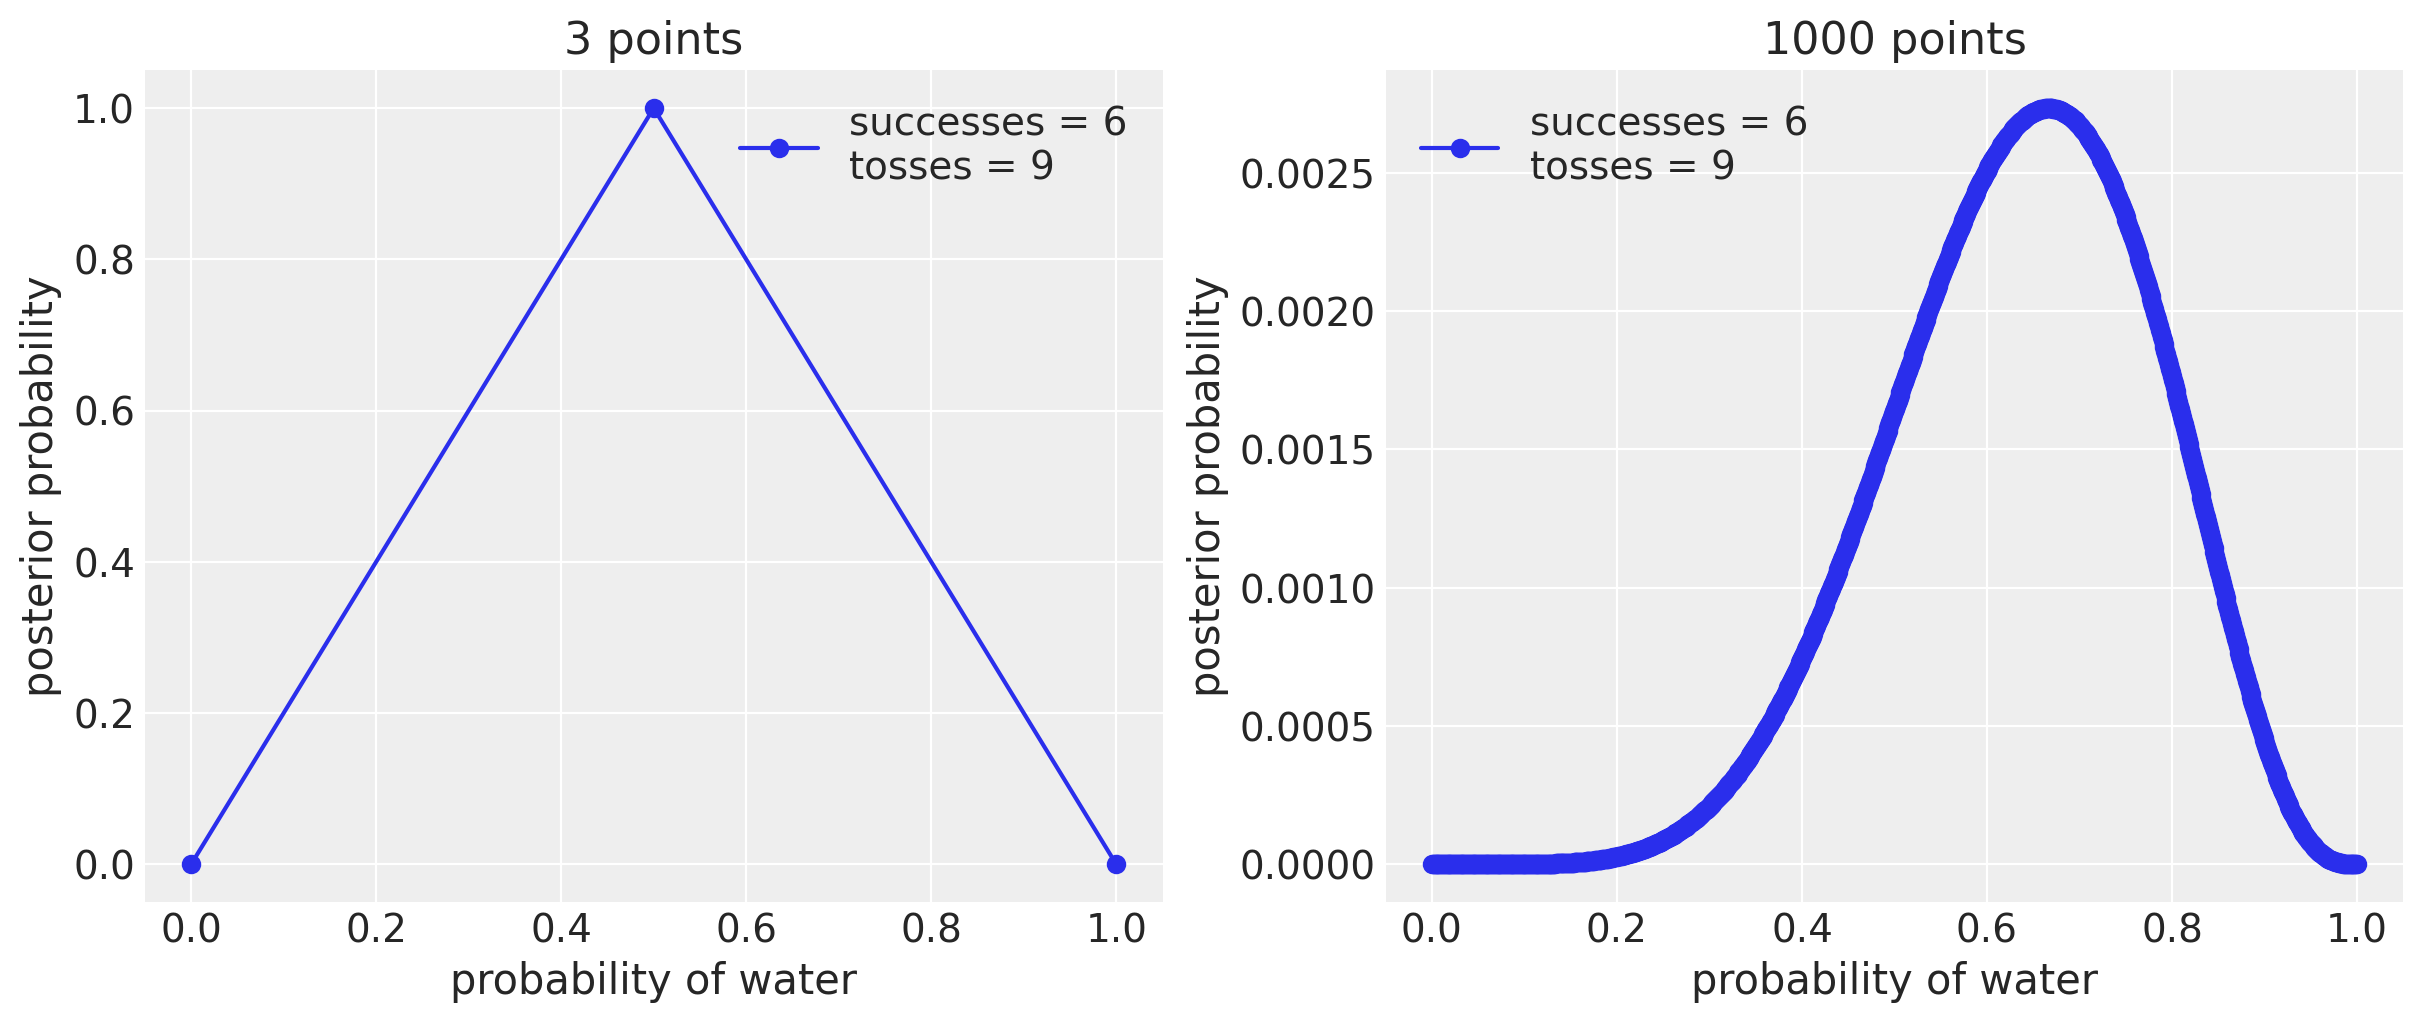

In [52]:
w, n = 6, 9

_, ax = plt.subplots(1, 2, figsize=(12, 5))

points = (3, 1000)
for idx, ps in enumerate(points):
    p_grid, posterior = posterior_grid_approx(ps, w, n)
    ax[idx].plot(p_grid, posterior, "o-", label=f"successes = {w}\ntosses = {n}")
    ax[idx].set_xlabel("probability of water")
    ax[idx].set_ylabel("posterior probability")
    ax[idx].set_title(f"{ps} points")
    ax[idx].legend(loc=0)

#### Sampling from the posterior
Recipe:
1. Compute or approximate posterior
2. Sample with replacement from posterior
3. Compute stuff from samples

In [17]:
np.repeat((0,1), (3,6))

array([0, 0, 0, 1, 1, 1, 1, 1, 1])

### Quadratic Approximation

In [45]:
data = np.repeat((0, 1), (12, 24))
with pm.Model() as normal_approximation:
    p = pm.Uniform("p", 0, 1)  # uniform priors
    w = pm.Binomial("w", n=len(data), p=p, observed=data.sum())  # binomial likelihood
    mean_q = pm.find_MAP()
    std_q = ((1 / pm.find_hessian(mean_q, vars=[p])) ** 0.5)[0]

# display summary of quadratic approximation
print("  Mean, Standard deviation\np {:.2}, {:.2}".format(mean_q["p"], std_q[0]))



  Mean, Standard deviation
p 0.67, 0.079


In [46]:
# Compute the 89% percentile interval
norm = stats.norm(mean_q, std_q)
prob = 0.89
z = stats.norm.ppf([(1 - prob) / 2, (1 + prob) / 2])
pi = mean_q["p"] + std_q * z
print("5.5%, 94.5% \n{:.2}, {:.2}".format(pi[0], pi[1]))


5.5%, 94.5% 
0.54, 0.79


### 3. Analytical Calculation

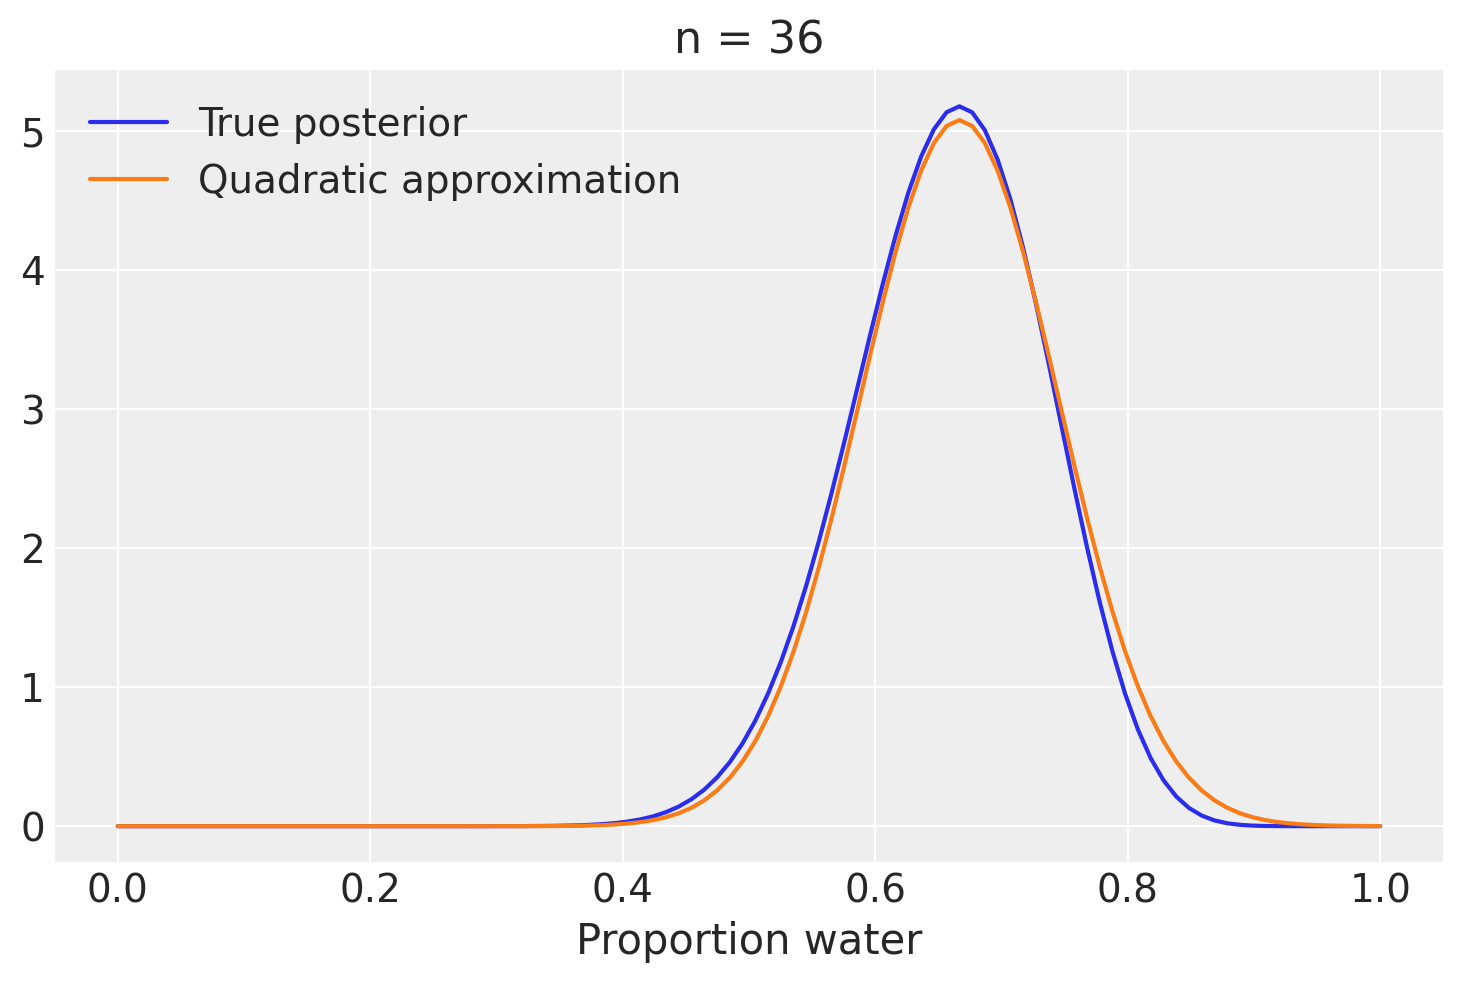

In [47]:
# analytical calculation
w, n = 24, 36
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x, w + 1, n - w + 1), label="True posterior")

# quadratic approximation
plt.plot(x, stats.norm.pdf(x, mean_q["p"], std_q), label="Quadratic approximation")
plt.legend(loc=0)

plt.title(f"n = {n}")
plt.xlabel("Proportion water");


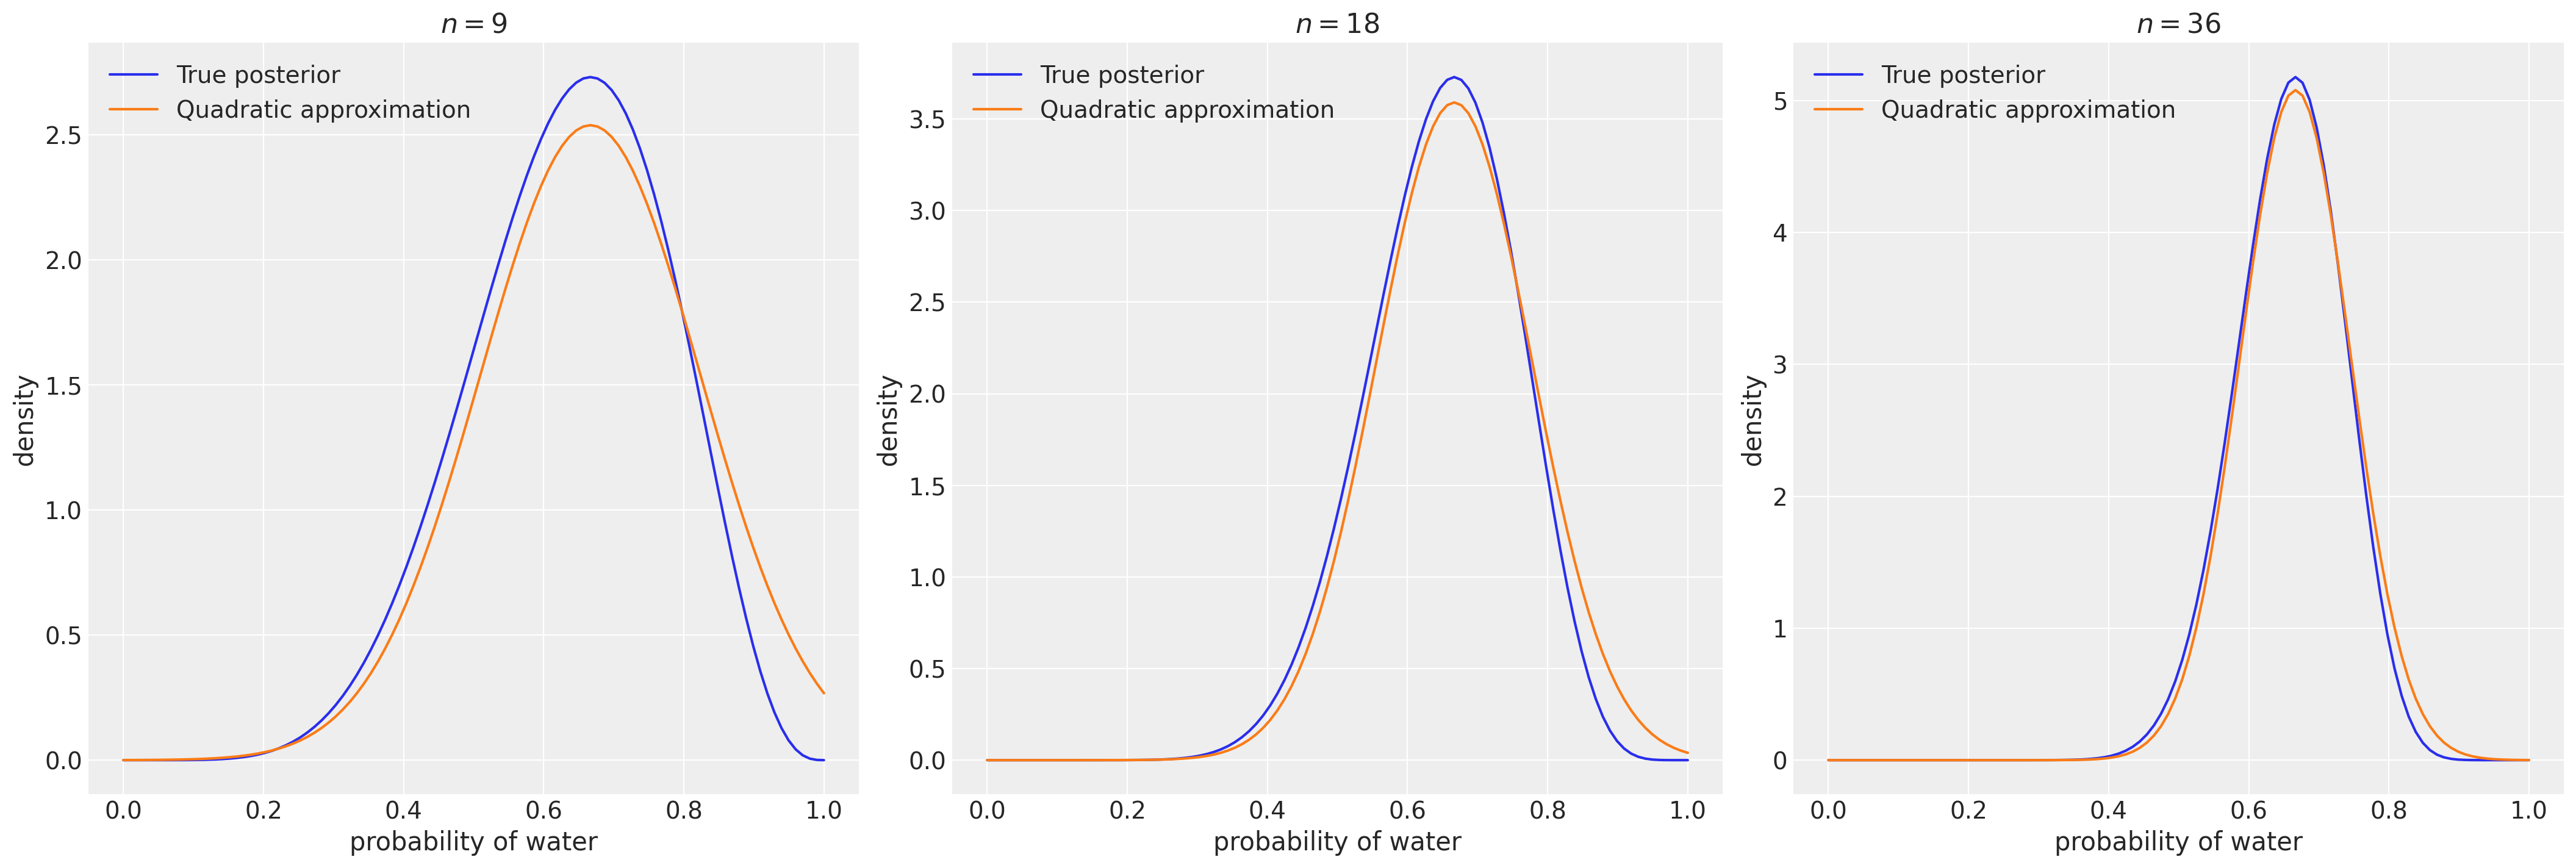

In [56]:
x = np.linspace(0, 1, 100)
w, n = [6, 12, 24], [9, 18, 36]

fig, ax = plt.subplots(1, 3, figsize=(21, 7))

for idx, ps in enumerate(zip(w, n)):
    data = np.repeat((0, 1), (ps[1] - ps[0], ps[0]))
    with pm.Model() as normal_approximation:
        p = pm.Uniform("p", 0, 1)  # uniform priors
        w = pm.Binomial("w", n=len(data), p=p, observed=data.sum())  # binomial likelihood
        mean_q = pm.find_MAP()
        std_q = ((1 / pm.find_hessian(mean_q, vars=[p])) ** 0.5)[0]

    ax[idx].plot(x, stats.beta.pdf(x, ps[0] + 1, ps[1] - ps[0] + 1), label="True posterior")
    ax[idx].plot(x, stats.norm.pdf(x, mean_q["p"], std_q), label="Quadratic approximation")
    ax[idx].set_xlabel("probability of water")
    ax[idx].set_ylabel("density")
    ax[idx].set_title(r"$n={}$".format(ps[1]))
    ax[idx].legend(loc="upper left")


### Markov chain Monte Carlo

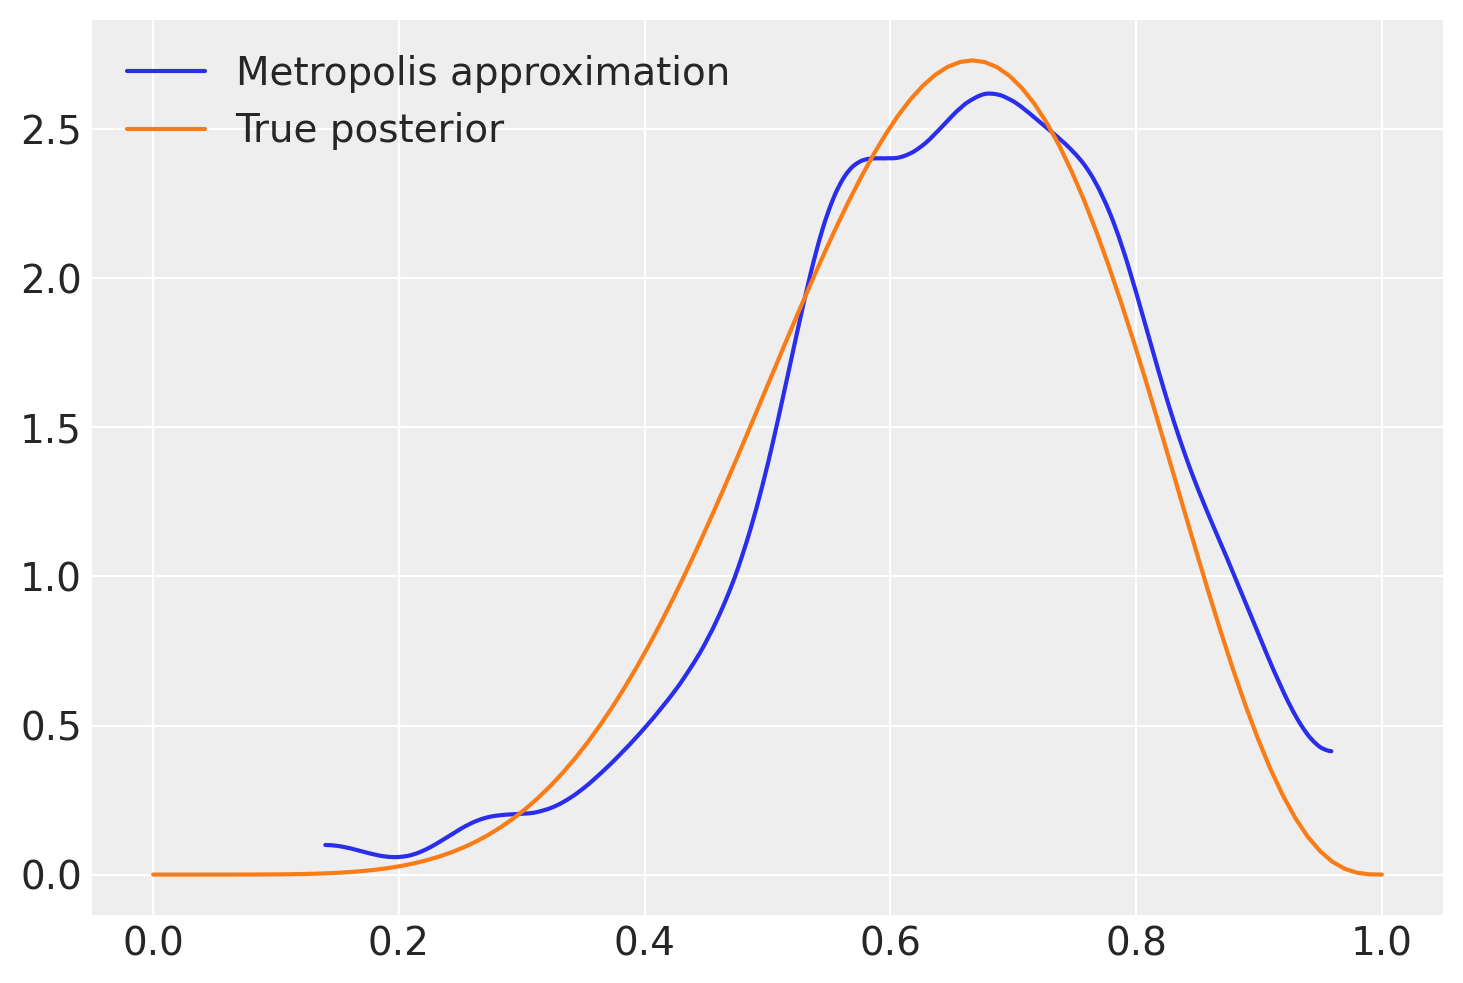

In [57]:
n_samples = 1000
p = np.zeros(n_samples)
p[0] = 0.5
W = 6
L = 3
for i in range(1, n_samples):
    p_new = stats.norm(p[i - 1], 0.1).rvs(1)
    if p_new < 0:
        p_new = -p_new
    if p_new > 1:
        p_new = 2 - p_new
    q0 = stats.binom.pmf(W, n=W + L, p=p[i - 1])
    q1 = stats.binom.pmf(W, n=W + L, p=p_new)
    if stats.uniform.rvs(0, 1) < q1 / q0:
        p[i] = p_new
    else:
        p[i] = p[i - 1]

az.plot_kde(p, label="Metropolis approximation")
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x, W + 1, L + 1), "C1", label="True posterior")
plt.legend();